In [3]:
%pylab inline
from __future__ import division
from copy import deepcopy as dc
import statsmodels.formula.api as smf
import numpy as np
import random as rd
import pylab as pl
import pandas as pd
import networkx as nx
import time
pl.rcParams.update({'font.size':15,'font.family':"STIXGeneral",'mathtext.fontset':'stix'})

Populating the interactive namespace from numpy and matplotlib


In [8]:
def bass(params,T): #扩散函数
    diffu_cont = np.zeros(T)
    t_list = np.arange(1,T+1)
    a = np.array([1 - np.exp(-(params[0]+params[1])*t) for t in t_list])
    b = np.array([1 + params[1]/params[0]*np.exp(-(params[0]+params[1])*t) for t in t_list])
    diffu_cont = params[2]*a/b

    adopt_cont = np.zeros_like(diffu_cont)
    adopt_cont[0] = diffu_cont[0]
    for t in xrange(1,T):
        adopt_cont[t] = diffu_cont[t] - diffu_cont[t-1]

    return adopt_cont


In [5]:
class Random_Grid_Search:
    t_n = 500 #抽样量
    c_n = 50 #保留参数量
    threshold = 1e-6 #循环停止阈值
    repetes = 1 #重复次数
    orig_points = [] #初始化边界点
    def __init__(self,s): #初始化实例参数
        self.s = np.array(s)  #待拟合曲线
        self.s_len = len(s)
        self.para_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #参数范围
        self.p_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #用于产生边界节点的参数范围 
    
    def genera_orig(self): #递归产生边界点
        if len(self.p_range) == 0:
            return
        else:  
            pa = self.p_range[-1]
            if self.orig_points == []:
                self.orig_points = [[pa[0]],[pa[1]]]  #初始化,排除orig_points为空的情形
            else:
                self.orig_points = [[pa[0]]+x for x in self.orig_points]+[[pa[1]]+x for x in self.orig_points]  #二分裂
            self.p_range.pop()
            return self.genera_orig()
    
    def sample(self,c_range): #抽样参数点
        p_list = []
        for pa in c_range:
            if isinstance(pa[0],float):
                x = (pa[1]-pa[0])*np.random.random(self.t_n) + pa[0]
            else:
                x = np.random.randint(low=pa[0],high=pa[1]+1,size=self.t_n)
            p_list.append(x)

        p_list = np.array(p_list).T
        return p_list.tolist()
    
    def f(self,params): #扩散函数
        diffu_cont = np.zeros(self.s_len)
        t_list = np.arange(1,self.s_len+1)
        a = np.array([1 - np.exp(-(params[0]+params[1])*t) for t in t_list])
        b = np.array([1 + params[1]/params[0]*np.exp(-(params[0]+params[1])*t) for t in t_list])
        diffu_cont = params[2]*a/b

        adopt_cont = np.zeros_like(diffu_cont)
        adopt_cont[0] = diffu_cont[0]
        for t in xrange(1,self.s_len):
            adopt_cont[t] = diffu_cont[t] - diffu_cont[t-1]

        return adopt_cont

    def mse(self,params):  #定义适应度函数（mse）
        a = self.f(params)
        tse = np.square(self.s-a)
        return np.mean(tse) #均方误
    
    def r2(self,params):
        a = np.array(self.f(params))
        tse = np.sum(np.square(self.s-a))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s-mean_y))
        return (ssl-tse)/ssl
    
    def optima_search(self):
        solution_cont = []
        self.genera_orig()
        
        for i in xrange(self.repetes):
            c_range = dc(self.para_range)
            samp = self.sample(c_range)
            solution = sorted([self.mse(x)]+x for x in samp+self.orig_points)[:self.c_n]
            u = 1
            while 1:
                params_min = np.min(np.array(solution),0) #最小值
                params_max = np.max(np.array(solution),0) #最大值
                c_range = [[params_min[j+1],params_max[j+1]] for j in range(len(c_range))] #重新定界
                samp = self.sample(c_range)
                solution = sorted([[self.mse(x)]+x for x in samp]+solution)[:self.c_n]
                r = sorted([x[0] for x in solution])
                v = (r[-1]-r[0])/r[0]
                if v < self.threshold:
                    break
                
                if u > 100:
                    print 'Searching ends in 100 runs'
                    break
                
                u += 1

            solution_cont.append(solution[0])

        solution = np.array(solution_cont)
        estimates = np.median(solution,axis=0)[1:]
        R2 = self.r2(estimates)
        return estimates,R2,solution
    
    def draw_curve(self,estms):
        f1 = self.f(estms)
        fig = pl.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        ax.plot(np.arange(1,self.s_len+1),self.s,'bo',label=r'$actual$')
        ax.plot(np.arange(1,self.s_len+1),f1,'r-',linewidth = 1.2,label=r'$fitted$')
        ax.set_title(r'Fitted and actual curve',fontsize=12)
        ax.set_xlabel(r'Time',fontsize=15)
        ax.set_ylabel(r'Sales',fontsize=15)
        ax.set_xlim([1,self.s_len])
        ax.legend(loc = 'best',fontsize=15)
        ax.grid(True) 

In [6]:
sigma_cont = ['sigma-0','sigma-0.1','sigma-0.2','sigma-0.4','sigma-0.6','sigma-0.8','sigma-1','sigma-1.2']

### 3步向前预测

In [11]:
for u in sigma_cont:
    print u
    diff_cont = np.load("%s.npy"%u)
    coeff_cont = np.load('estimate %s.npy'%u)

    pe_cont = []
    pep_cont = []
    
    time1 = time.clock()
    for i in range(len(diff_cont)):
        diff = diff_cont[i]
        coeff = coeff_cont[i]
        
        s_full = diff[2:]
        max_idx = np.argmax(s_full)
        params = coeff[1]
        bass_diff = bass(params,max_idx+5)

        error_series = bass_diff[max_idx+2:max_idx+5]-s_full[max_idx+2:max_idx+5]        #计算差值
        pe_cont.append([coeff[0],error_series])

        error_series_percent = error_series/s_full[max_idx+2:max_idx+5]        #计算百分误差
        pep_cont.append([coeff[0],error_series_percent])

    print 'Time elasped:',time.clock()-time1

    np.save("%s-pe"%u,pe_cont)
    np.save("%s-pep"%u,pep_cont)

sigma-0
Time elasped: 0.00598088954968
sigma-0.1
Time elasped: 0.00622493766937
sigma-0.2
Time elasped: 0.00586656326934
sigma-0.4
Time elasped: 0.00622750359588
sigma-0.6
Time elasped: 0.00580583634238
sigma-0.8
Time elasped: 0.00625401816961
sigma-1
Time elasped: 0.00586057610752
sigma-1.2
Time elasped: 0.00624090343422


### 逐步估计一步向前

In [13]:
for u in sigma_cont:
    diff_cont = np.load("%s.npy"%u)

    params_cont = []
    pe_cont = []
    pep_cont = []
    
    time1 = time.clock()
    for x in diff_cont:
        s_full = x[2:]
        max_idx = np.argmax(s_full)     
        A_list = [max_idx ,max_idx +1,max_idx +2,max_idx +3,max_idx +4]
        est_cont = [x[:2]]
        pe = []
        pep = []
        for A in A_list:
            s_act = s_full[:A]
            len_actual = len(s_act)
            rgs = Random_Grid_Search(s_act)
            estim,r2=rgs.optima_search()[:2]
            est_cont.extend([estim,r2])

            e_sale = bass(estim,A+1)
            error = e_sale[A] - s_full[A]  #one step ahead prediction
            pe.append(error)
            error_percent = error/s_full[A]
            pep.append(error_percent)

        params_cont.append(est_cont)
        pe_cont.append(pe)
        pep_cont.append(pep)
    print 'Time elasped:',time.clock()-time1

    np.save("%s(x5)-params"%u,params_cont)
    np.save("%s(x5)-pe"%u,pe_cont)
    np.save("%s(x5)-pep"%u,pep_cont)

Time elasped: 409.065744169
Time elasped: 429.477046219
Time elasped: 439.915680804
Time elasped: 432.121223776
Time elasped: 421.849106701
Searching ends in 100 runs
Searching ends in 100 runs
Time elasped: 394.529392545
Searching ends in 100 runs
Time elasped: 380.064541604
Searching ends in 100 runs
Searching ends in 100 runs
Searching ends in 100 runs
Searching ends in 100 runs
Searching ends in 100 runs
Time elasped: 399.227900174


### (3)绘图

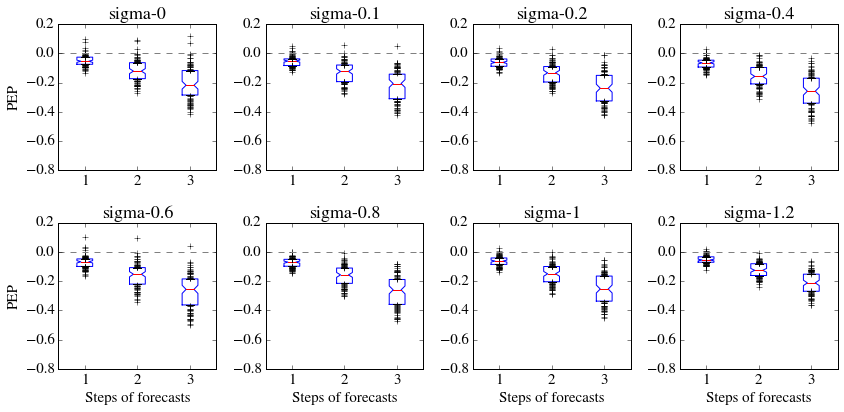

In [24]:
sigma_cont = ['0','0.1','0.2','0.4','0.6','0.8','1','1.2']
fig = pl.figure(figsize = (12,6))
i = 1
for u in sigma_cont:
    predict_error_percent = np.load('sigma-%s-pep.npy'%u)
    B_data = [x[0][1] for x in predict_error_percent]
    C_data_1 = [x[1][0] for x in predict_error_percent]
    C_data_2 = [x[1][1] for x in predict_error_percent]
    C_data_3 = [x[1][2] for x in predict_error_percent]
    data = [C_data_1,C_data_2,C_data_3]

    ax = fig.add_subplot(2,4,i)
    ax.boxplot(data,notch=1,vert =1,whis=0,widths = 0.3,positions = np.arange(1,4) )
    ax.axhline(0,color='gray',ls = '--', lw = 1)
    ax.set_ylim([-0.8,0.2])
    ax.set_title(r'%s'%title_cont[i-1])
    if i >= 5:
        ax.set_xlabel('Steps of forecasts',fontsize=15)
    if i == 1 or i == 5 or i == 9 or i==13:
        ax.set_ylabel('PEP',fontsize=15)
    
    i = i+1
    
pl.tight_layout()

### 逐步估计一步向前

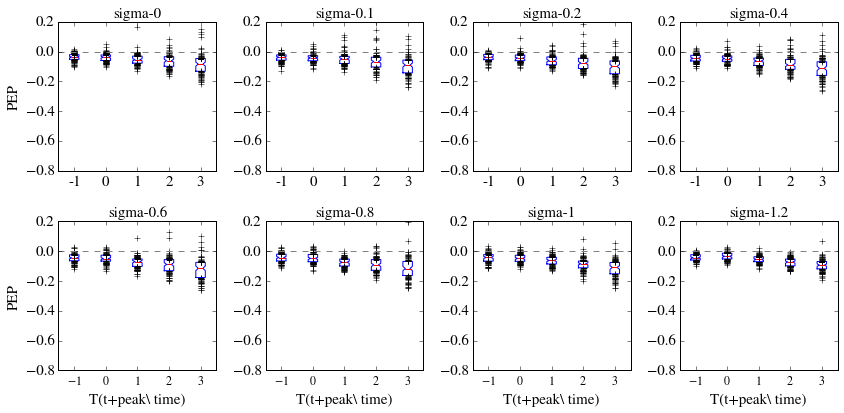

In [21]:
sigma_cont = ['sigma-0','sigma-0.1','sigma-0.2','sigma-0.4','sigma-0.6','sigma-0.8','sigma-1','sigma-1.2']
title_cont = ['sigma-0','sigma-0.1','sigma-0.2','sigma-0.4','sigma-0.6','sigma-0.8','sigma-1','sigma-1.2']
fig = pl.figure(figsize = (12,6))
i = 1
for u in sigma_cont:
    pep = np.load('%s(x5)-pep.npy'%u) 
    pep1 = [x[0] for x in pep]
    pep2 = [x[1] for x in pep]
    pep3 = [x[2] for x in pep]
    pep4 = [x[3] for x in pep]
    pep5 = [x[4] for x in pep]
    data = [pep1,pep2,pep3,pep4,pep5]
        
    ax = fig.add_subplot(2,4,i)
    ax.boxplot(data,notch=1,vert =1,whis=0,widths = 0.3,positions = [-1,0,1,2,3])
    ax.axhline(0,color='gray',ls = '--', lw = 1)
    ax.set_ylim([-0.8,0.2])
    ax.set_title(r'%s'%title_cont[i-1],fontsize=15)

    if i >= 5:
        ax.set_xlabel(r'T(t+peak time)',fontsize=15)
        ax.set_xticklabels([r'$-1$', r'$0$', r'$1$', r'$2$', r'$3$'], fontsize=12)
    if i == 1 or i == 5:
        ax.set_ylabel('PEP',fontsize=15)
    
    i = i+1

pl.tight_layout()